In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split # Used for data splitting
import pickle
import matplotlib.pyplot as plt
import cv2 # For attention overlay visualization

In [12]:
DATA_DIR = '.' 
IMG_SIZE = 224 
BATCH_SIZE = 16

NUM_HEADS = 4         # Number of attention heads
TRANSFORMER_LAYERS = 3 # Number of Transformer blocks
PROJECTION_DIM = 192  # Output dimension of the CNN features as input to Transformer, i.e. projection dimensions
FFN_DIM = 512         # Hidden dimensions in the Feed-Forward Network

In [14]:
@tf.keras.utils.register_keras_serializable()
class ClassTokenInsertion(layers.Layer): #Custom layer to prepend a learnable [CLS] token to a sequence.
    def __init__(self, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.class_token = self.add_weight(
            shape=(1, 1, self.projection_dim),
            initializer="zeros",
            trainable=True,
            name="class_token",
        )
        super().build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_token = tf.tile(self.class_token, [batch_size, 1, 1])
        return tf.concat([cls_token, inputs], axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({"projection_dim": self.projection_dim})
        return config

@tf.keras.utils.register_keras_serializable()
class PositionEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        self.position_embedding = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
    
    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        return inputs + self.position_embedding(positions)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "embed_dim": self.embed_dim,
        })
        return config


@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer): #Vision Transformer Encoder Block with Attention Score output.
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        # FIX 4: REMOVED 'return_attention_scores=True' from __init__
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim,
            dropout=rate,
            output_shape=(embed_dim,), 
            name="multi_head_attention"
        )
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="gelu"),
            layers.Dropout(0.3),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)


    # FIX 5: Explicit shape passing for MultiHeadAttention during build
    def build(self, input_shape):
        # input_shape is (None, SEQUENCE_LENGTH, PROJECTION_DIM)
        # Pass input_shape for Query, Key, and Value
        self.att.build(input_shape, input_shape, input_shape) 
        self.ffn.build(self.layernorm1.compute_output_shape(input_shape))
        super().build(input_shape)


    # FIX 6: Pass return_attention_scores=True in the call method
    def call(self, inputs, training=False):
        # MHA returns a tuple: (Output, Attention_Scores)
        attn_output, attention_scores = self.att(
            inputs, inputs, return_attention_scores=True, training=training
        )
        
        # Skip connection 1 + Norm
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-Forward Network
        ffn_output = self.ffn(out1)
        
        # Skip connection 2 + Norm
        output = self.layernorm2(out1 + ffn_output)
        
        # Return both the sequence result and the attention scores
        return output, attention_scores 

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

In [7]:
# --- Data Loading and Preprocessing --
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
LABELS_PATH = os.path.join(DATA_DIR, 'labels.csv')
BREEDS_PATH = os.path.join(DATA_DIR, 'dog_breeds.pkl')

# Ensuring directories exist 
if not os.path.exists(TRAIN_DIR) or not os.path.exists(LABELS_PATH):
    print("WARNING: Data files (train/ or labels.csv) not found. This cell may fail if data is not present.")

# Load labels and create mappings
df_labels = pd.read_csv(LABELS_PATH)
BREEDS = sorted(df_labels['breed'].unique())
NUM_CLASSES = len(BREEDS)

# ESSENTIAL : Saving the breeds list for prediction
with open(BREEDS_PATH, 'wb') as f:
    pickle.dump(BREEDS, f)
print(f"Total number of dog breeds: {NUM_CLASSES}")

Total number of dog breeds: 120


In [40]:
# Create dataset mapping
label_map = dict(zip(df_labels['id'], df_labels['breed']))
file_paths_and_labels = []
for file_id, breed_name in label_map.items():
    file_path = os.path.join(TRAIN_DIR, f"{file_id}.jpg")
    breed_index = BREEDS.index(breed_name)
    file_paths_and_labels.append((file_path, breed_index))

df_files = pd.DataFrame(file_paths_and_labels, columns=['filepath', 'label'])
df_train, df_val = train_test_split(
    df_files,
    test_size=0.2, 
    stratify=df_files['label'],
    random_state=42
)
# --- Data Augmentation Layer ---
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.15),
], name="data_augmentation")


In [41]:
# Function to load and preprocess images
def load_and_preprocess(filepath, label, augment=False):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    if augment:
        img = data_augment(img)

    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, label


# Create TensorFlow Datasets
def make_dataset(df, shuffle=True, augment=False):
    filepaths = df['filepath'].values
    labels = df['label'].values

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    dataset = dataset.map(
        lambda fp, lbl: load_and_preprocess(fp, lbl, augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1024)

    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = make_dataset(df_train, shuffle=True, augment=True)
val_ds   = make_dataset(df_val, shuffle=False, augment=False)

In [42]:
def create_hybrid_model():
    # 1. CNN Head (Feature Extractor)
    resnet_model = keras.applications.ResNet50V2(
        include_top=False, 
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    resnet_model.trainable = False 
    cnn_output = resnet_model.output

    # 2. Patching and Embedding
    x = layers.Conv2D(PROJECTION_DIM, kernel_size=1, padding="valid", name="cnn_projection")(cnn_output)
    
    _, h, w, c = x.shape
    SEQUENCE_LENGTH_WITHOUT_CLS = h * w
    
    x = layers.Reshape((SEQUENCE_LENGTH_WITHOUT_CLS, c), name="patch_flatten")(x)
    
    # Add Learnable Class Token [CLS]
    x = ClassTokenInsertion(PROJECTION_DIM, name="class_token_insertion")(x)
    
    # Add Positional Embeddings
    SEQUENCE_LENGTH = SEQUENCE_LENGTH_WITHOUT_CLS + 1 
    x = PositionEmbedding(SEQUENCE_LENGTH, PROJECTION_DIM, name="position_embedding")(x)
    x = layers.Dropout(0.35)(x)
    
    # Placeholder for the attention scores
    attention_scores_output = None

    # 3. ViT Body (Transformer Encoder Blocks)
    for i in range(TRANSFORMER_LAYERS):
        # TransformerBlock returns a tuple: (sequence_output, attention_scores)
        x, attention_scores = TransformerBlock(
            PROJECTION_DIM, NUM_HEADS, FFN_DIM, name=f"transformer_block_{i}"
        )(x)
        
        # Capture the attention scores from the LAST block
        if i == TRANSFORMER_LAYERS - 1:
            # FIX: Name the attention output explicitly for cleaner loading/access
            attention_scores_output = layers.Identity(name='attention_scores_output')(attention_scores) 

    # 4. Classification Head
    representation = x[:, 0]
    
    logits = layers.Dense(NUM_CLASSES, activation='softmax', name="output")(representation)

    # FIX: Create the model with TWO outputs: prediction and attention scores
    model = keras.Model(
        inputs=resnet_model.input, 
        outputs=[logits, attention_scores_output]
    )
    return model

model = create_hybrid_model()
print("Hybrid Model created with two outputs: [Prediction, Attention Scores]")

Hybrid Model created with two outputs: [Prediction, Attention Scores]


In [43]:
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_18[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 56, 56, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 56, 56, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 58, 58, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 26,362,360 (100.56 MB)

 Trainable params: 2,797,560 (10.67 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

optimizer = keras.optimizers.Adam(learning_rate=2e-5, weight_decay=1e-4) 
EPOCHS = 50 

# --- Callbacks ---
checkpoint_filepath = os.path.join(DATA_DIR, 'robust_hybrid_model.keras')
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, 
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopper = EarlyStopping(
    monitor='val_loss',         
    patience=3,                 
    restore_best_weights=True,  
    mode='min'                  
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)

In [48]:
# Compile and Train with a list of losses: Loss for output, None for attention_scores_output
model.compile(
    optimizer=optimizer,
    loss=[keras.losses.SparseCategoricalCrossentropy(), None], 
    metrics={
        "output": ["accuracy"],  # Metrics for the first output (Logits)
        "attention_scores_output": [],      # No metrics for the second output (Attention Scores)
    },
)

In [49]:
# Actual Training
print("\nStarting Robust Training...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopper, model_checkpoint_callback] 
)

print(f"\nTraining complete! Model saved successfully to: {checkpoint_filepath}")


Starting Robust Training...
Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 242s 453ms/step - loss: 3.2479 - output_accuracy: 0.3068 - val_loss: 1.9263 - val_output_accuracy: 0.5800
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 219s 426ms/step - loss: 1.8637 - output_accuracy: 0.5848 - val_loss: 1.4305 - val_output_accuracy: 0.6694
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 216s 420ms/step - loss: 1.5059 - output_accuracy: 0.6527 - val_loss: 1.2416 - val_output_accuracy: 0.6934
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 216s 420ms/step - loss: 1.3223 - output_accuracy: 0.6831 - val_loss: 1.1396 - val_output_accuracy: 0.7110
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 217s 423ms/step - loss: 1.1904 - output_accuracy: 0.7029 - val_loss: 1.0787 - val_output_accuracy: 0.7139
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 218s 424ms/step - loss: 1.0950 - output_accuracy: 0.7229 - val_loss: 1.0503 - val_output_accuracy: 0.7120
Epoch 7/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 217s 423ms/step - loss: 1.0388 - output_accuracy: 0.733

In [50]:
results = model.evaluate(train_ds, verbose=1)
print("\n--- Evaluation Results of Training ---")
print(f"Training Loss: {results[0]:.4f}")
print(f"Training Accuracy: {results[1]:.4f}")

512/512 ━━━━━━━━━━━━━━━━━━━━ 363s 708ms/step - loss: 0.5443 - output_accuracy: 0.8535

--- Evaluation Results of Training ---
Training Loss: 0.5443
Training Accuracy: 0.8535


In [51]:
results = model.evaluate(val_ds, verbose=1)
print("\n--- Evaluation Results of Validation---")
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")

128/128 ━━━━━━━━━━━━━━━━━━━━ 90s 704ms/step - loss: 0.9186 - output_accuracy: 0.7242

--- Evaluation Results of Validation---
Validation Loss: 0.9186
Validation Accuracy: 0.7242


In [52]:
import pickle
import os

SAVE_DIR = '.' # Saving in the current directory
MODEL_FILENAME = 'dog_breed_hybrid_model.keras'
BREEDS_FILENAME = 'dog_breeds.pkl'

# 1. Save the Model
MODEL_PATH = os.path.join(SAVE_DIR, MODEL_FILENAME)
# Keras automatically handles saving custom layers (TransformerBlock, PositionEmbedding) when saving in the .keras format.
model.save(MODEL_PATH) 
print(f"Model saved successfully to: {MODEL_PATH}")

# 2. Save the list of breeds (classes)
BREEDS_PATH = os.path.join(SAVE_DIR, BREEDS_FILENAME)
with open(BREEDS_PATH, 'wb') as f:
    pickle.dump(BREEDS, f) 
print(f"Breeds list saved successfully to: {BREEDS_PATH}")

Model saved successfully to: .\dog_breed_hybrid_model.keras
Breeds list saved successfully to: .\dog_breeds.pkl


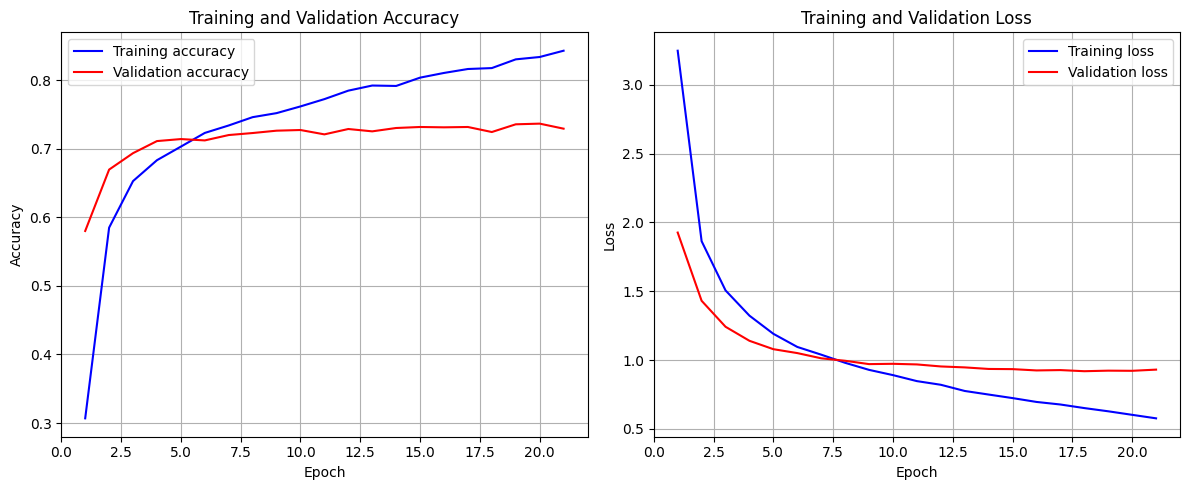

In [54]:
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    # Get the data from the history object
    acc = history.history['output_accuracy']
    val_acc = history.history['val_output_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # --- Plot Accuracy ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Plot Loss ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
# Execute the function after training is complete
plot_learning_curves(history)

In [57]:
import os
import tensorflow as tf

# --- Configuration (Must match training setup) ---
DATA_DIR = '.' 
IMG_SIZE = 224 

MODEL_PATH = os.path.join(DATA_DIR, 'robust_hybrid_model.keras')
TEST_DIR = os.path.join(DATA_DIR, 'test')


# 1. Load the model
try:
    # This assumes the model was saved successfully in Cell 4
    loaded_model = tf.keras.models.load_model(MODEL_PATH) 
    print(f"✅ Model loaded successfully from: {MODEL_PATH}")
except Exception as e:
    print(f"❌ ERROR: Could not load model. Ensure the file exists at {MODEL_PATH}. Error: {e}")
    # Set loaded_model to None so the visualization check doesn't throw a NameError
    loaded_model = None

# 2. Find test files
try:
    if os.path.exists(TEST_DIR):
        # Find all files ending with .jpg in the test directory
        test_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith('.jpg')]
        print(f"✅ Found {len(test_files)} test images.")
    else:
        test_files = []
        print(f"⚠️ Warning: Test directory not found at {TEST_DIR}. Cannot run visualization.")
except Exception as e:
    test_files = []
    print(f"❌ Error finding test files: {e}")

✅ Model loaded successfully from: .\robust_hybrid_model.keras
✅ Found 10357 test images.


In [58]:
def visualize_attention_map(model, img_path, img_size):
    #Generates and overlays the attention map from the CLS token onto the image, using the model's second output tensor (attention scores).
    if not os.path.exists(img_path):
        print(f"Error: Image not found at {img_path}")
        return

    # 1. Load and Preprocess the Image
    img = tf.keras.utils.load_img(img_path, target_size=(img_size, img_size))
    img_array = tf.keras.utils.img_to_array(img)
    # Use ResNetV2 preprocessing (must match training)
    preprocessed_img = tf.keras.applications.resnet_v2.preprocess_input(
        np.expand_dims(img_array, axis=0)
    )

    # 2. Get Attention Weights
    # The model predicts two things: [predictions[0], attention_weights[1]]
    _, attention_weights = model.predict(preprocessed_img)
    
    # 3. Process Attention Scores
    # a. Average weights across all heads (Result: (Seq_Length, Seq_Length))
    # attention_weights[0] is the (Num_Heads, Seq_Length, Seq_Length) tensor for the first image
    mean_attention = np.mean(attention_weights[0], axis=0) 
    
    # b. Get attention from the CLS token (index 0) to all patches (index 1 to end)
    # Result: (Seq_Length - 1,)
    cls_attention_to_patches = mean_attention[0, 1:] 
    
    # 4. Reshape and Resize the Map
    patch_side = int(np.sqrt(cls_attention_to_patches.shape[0]))
    if patch_side == 0:
        print("Error: Could not determine patch size from attention map.")
        return
        
    attention_map = cls_attention_to_patches.reshape(patch_side, patch_side)
    
    # Resize the map to the image size
    attention_map = cv2.resize(attention_map, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    
    # Normalize the map for color mapping
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-6)
    
    # 5. Overlay and Display
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    img_float = img_array / 255.0 
    plt.imshow(img_float)
    # Overlay the attention map with transparency and a heatmap color scheme
    plt.imshow(attention_map, alpha=0.6, cmap='jet') 
    plt.title('ViT Attention Map (CLS Token)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Visualizing attention for: 000621fb3cbb32d8935728e48679680e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003921569..0.003921569].


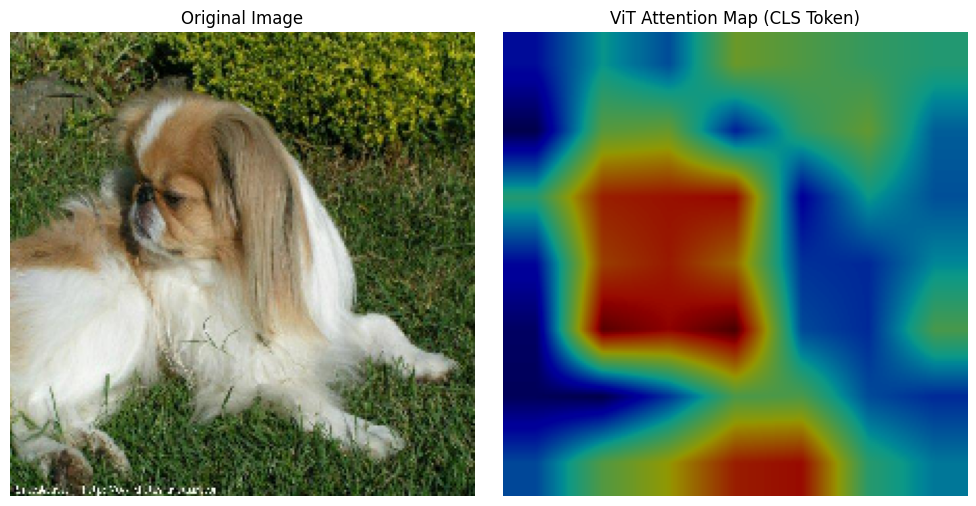

In [59]:
try:
    if 'loaded_model' in locals() and test_files:
        test_img_path = test_files[0] 
        print(f"Visualizing attention for: {os.path.basename(test_img_path)}")
        visualize_attention_map(loaded_model, test_img_path, IMG_SIZE)
    else:
        print("Cannot visualize: 'loaded_model' or 'test_files' not defined. Run previous cells first.")
except NameError:
    print("Cannot visualize: Required variables ('loaded_model', 'test_files') are not available in the current scope.")

Visualizing attention for: 00b29dbc49177cd4faeac3c485330af9.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003921569..0.0017993081].


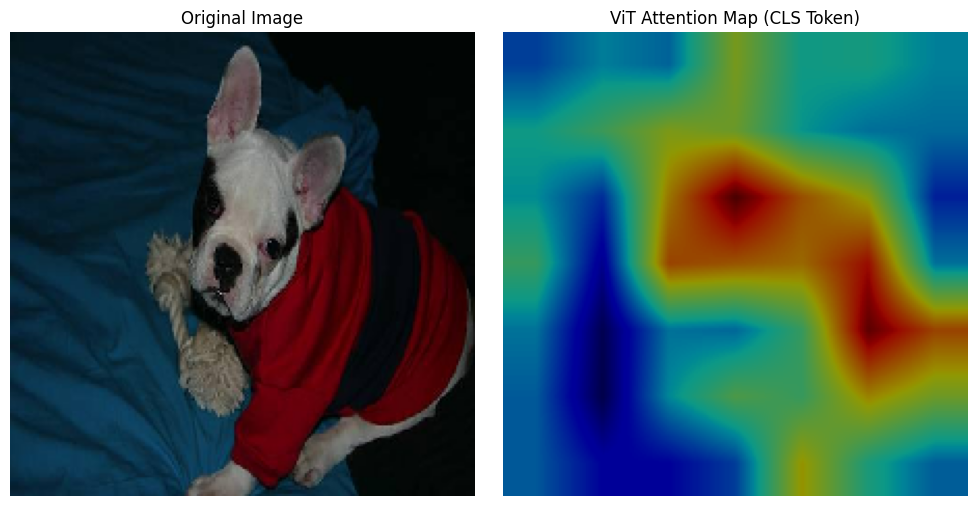

In [67]:
try:
    if 'loaded_model' in locals() and test_files:
        test_img_path = test_files[33] 
        print(f"Visualizing attention for: {os.path.basename(test_img_path)}")
        visualize_attention_map(loaded_model, test_img_path, IMG_SIZE)
    else:
        print("Cannot visualize: 'loaded_model' or 'test_files' not defined. Run previous cells first.")
except NameError:
    print("Cannot visualize: Required variables ('loaded_model', 'test_files') are not available in the current scope.")

In [69]:
from tqdm import tqdm
MODEL_PATH = os.path.join(DATA_DIR, 'robust_hybrid_model.keras')
TEST_DIR = os.path.join(DATA_DIR, 'test')
BREEDS_PATH = os.path.join(DATA_DIR, 'dog_breeds.pkl')

In [70]:
#loading model
try:
    # Load Model
    loaded_model = tf.keras.models.load_model(MODEL_PATH) 
    print(f"✅ Model loaded successfully from: {MODEL_PATH}")
    
    # Load Breeds List
    with open(BREEDS_PATH, 'rb') as f:
        BREEDS = pickle.load(f)
    print(f"✅ Loaded {len(BREEDS)} dog breeds.")

except Exception as e:
    print(f"❌ ERROR: Failed to load model or breeds. Ensure files exist. Error: {e}")
    # Exit if resources aren't loaded
    exit()

✅ Model loaded successfully from: .\robust_hybrid_model.keras
✅ Loaded 120 dog breeds.


In [71]:
def preprocess_and_predict(file_path):
    """Loads, preprocesses, and runs prediction on a single image file."""
    # Load and Preprocess image to the required size (224x224)
    img = tf.keras.utils.load_img(file_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0) 
    preprocessed_img = tf.keras.applications.resnet_v2.preprocess_input(img_batch)
    
    # Make Prediction (Returns [logits, attention_scores])
    predictions, _ = loaded_model.predict(preprocessed_img, verbose=0)
    
    return predictions[0]

In [72]:
# Get list of all test files
test_files = [f for f in os.listdir(TEST_DIR) if f.endswith('.jpg')]
if not test_files:
    print(f" Warning: No JPG files found in {TEST_DIR}. Aborting test run.")
    exit()

print(f"\nStarting prediction on {len(test_files)} test images...")

results = []

# Iterate through all test files with a progress bar
for file_name in tqdm(test_files):
    file_id = os.path.splitext(file_name)[0]
    file_path = os.path.join(TEST_DIR, file_name)
    
    # Getting vector of probabilities for all breeds 
    prob_vector = preprocess_and_predict(file_path)
    
    # Find the predicted breed
    predicted_index = np.argmax(prob_vector)
    predicted_breed = BREEDS[predicted_index]
    confidence = np.max(prob_vector)
    
    results.append({
        'id': file_id,
        'predicted_breed': predicted_breed.replace('_', ' ').title(),
        'confidence': confidence,
        # Store the full probability vector for deeper analysis (optional)
        'probabilities': prob_vector 
    })

df_results = pd.DataFrame(results)

# Display the top 10 results
print("\n--- Sample Prediction Results (Top 10) ---")
print(df_results[['id', 'predicted_breed', 'confidence']].head(10))

results_csv_path = os.path.join(DATA_DIR, 'test_predictions.csv') #saving into csv format
df_results.to_csv(results_csv_path, index=False)
print(f"\n✅ All {len(df_results)} predictions saved to: {results_csv_path}")


Starting prediction on 10357 test images...


100%|████████████████████████████████████████████████████████████████████████████| 10357/10357 [26:52<00:00,  6.42it/s]



--- Sample Prediction Results (Top 10) ---
                                 id       predicted_breed  confidence
0  000621fb3cbb32d8935728e48679680e      Japanese Spaniel    0.805293
1  00102ee9d8eb90812350685311fe5890               Samoyed    0.965462
2  0012a730dfa437f5f3613fb75efcd4ce        English Setter    0.598052
3  001510bc8570bbeee98c8d80c8a95ec1          Newfoundland    0.765729
4  001a5f3114548acdefa3d4da05474c2e                 Lhasa    0.571290
5  00225dcd3e4d2410dd53239f95c0352f  Bouvier Des Flandres    0.256785
6  002c2a3117c2193b4d26400ce431eebd    Australian Terrier    0.954897
7  002c58d413a521ae8d1a5daeb35fc803               Samoyed    0.946716
8  002f80396f1e3db687c5932d7978b196       Irish Wolfhound    0.577032
9  0036c6bcec6031be9e62a257b1c3c442        Sussex Spaniel    0.895193

✅ All 10357 predictions saved to: .\test_predictions.csv


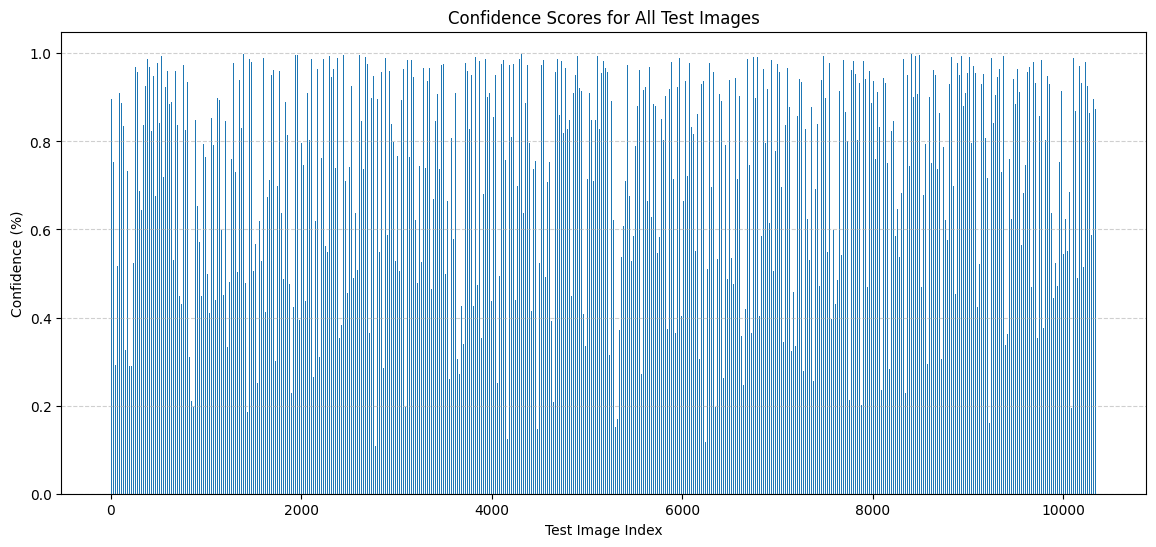

In [76]:
df = pd.read_csv("test_predictions.csv")
confidences = df["confidence"].values
plt.figure(figsize=(14,6))
plt.bar(range(len(confidences)), confidences)
plt.xlabel("Test Image Index")
plt.ylabel("Confidence (%)")
plt.title("Confidence Scores for All Test Images")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

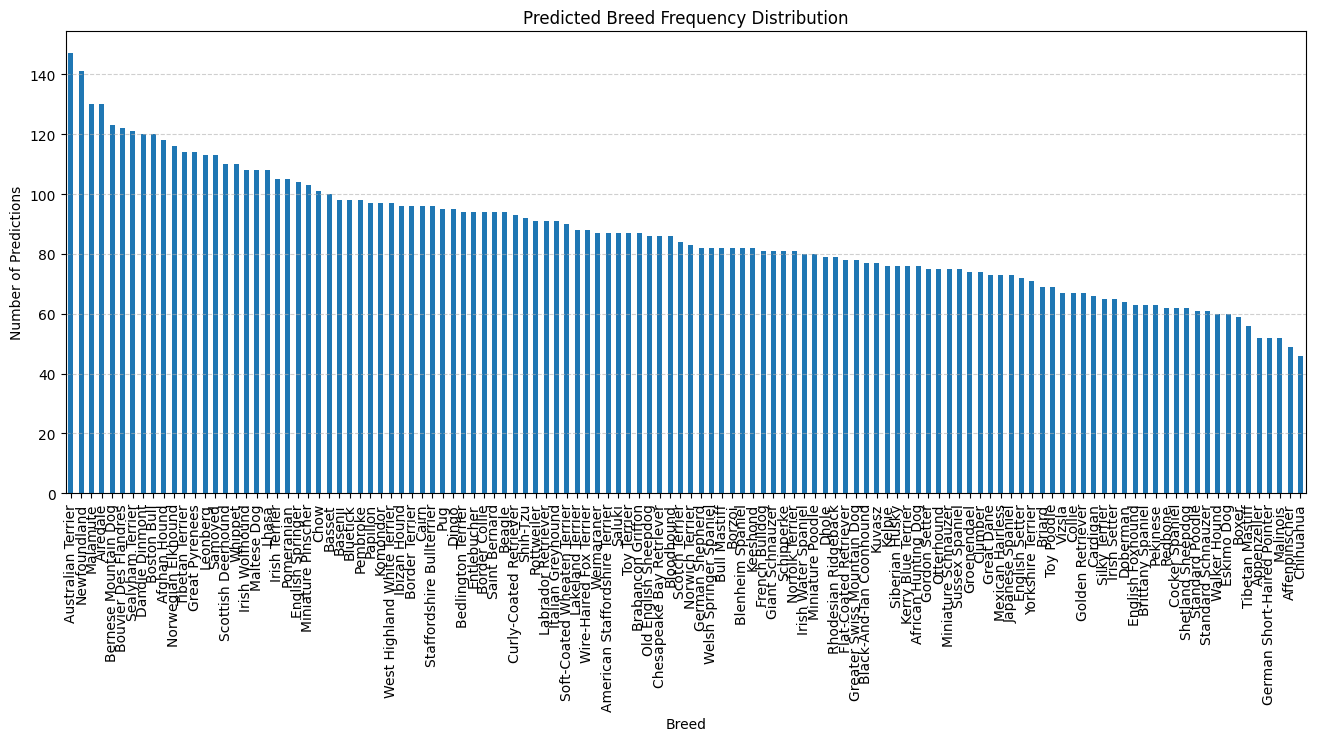

In [79]:
# Count breed occurrences
breed_counts = df["predicted_breed"].value_counts()

plt.figure(figsize=(16,6))
breed_counts.plot(kind='bar')

plt.title("Predicted Breed Frequency Distribution")
plt.xlabel("Breed")
plt.ylabel("Number of Predictions")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()